# Business Impact Analysis: XGBoost Model Financial Benefits

This notebook calculates the actual financial impact of implementing the XGBoost model for Lending Club's credit risk assessment, based on real data from the medallion architecture.


In [ ]:
# ======================================
# Import Libraries and Initialize Spark
# ======================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")

# Initialize Spark
from init_spark import start_spark

spark = start_spark()

print("✅ Libraries imported and Spark initialized successfully!")

4.0.0
✅ Libraries imported and Spark initialized successfully!


25/09/08 10:43:27 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [ ]:
# ======================================
# Load Lending Club Data from Medallion Architecture
# ======================================

# Load the cleaned data from the gold layer
df = spark.read.format("delta").load("../data/gold/medallion_cleaned_lc_data")

print("🎯 LENDING CLUB DATASET OVERVIEW")
print("=" * 60)
print(f"📊 Total Records: {df.count():,}")
print(f"📋 Total Features: {len(df.columns)}")

# Convert to Pandas for analysis
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
pdf = df.toPandas()

print(f"✅ Successfully loaded {pdf.shape[0]:,} loans with {pdf.shape[1]} features")

🎯 LENDING CLUB DATASET OVERVIEW
📊 Total Records: 1,339,155
📋 Total Features: 75


✅ Successfully loaded 1,339,155 loans with 75 features


📈 LENDING CLUB HISTORICAL LOAN ISSUANCE
 year  loans_issued
 2007           247
 2008          1526
 2009          4591
 2010         11440
 2011         21705
 2012         53267
 2013        134482
 2014        222052
 2015        373502
 2016        291849
 2017        168505
 2018         55989

🎯 KEY METRICS:
   📅 Date Range: 2007 - 2018
   📊 Total Years: 12
   📈 Average Loans/Year: 111,596
   📊 Peak Year: 2015 (373,502 loans)


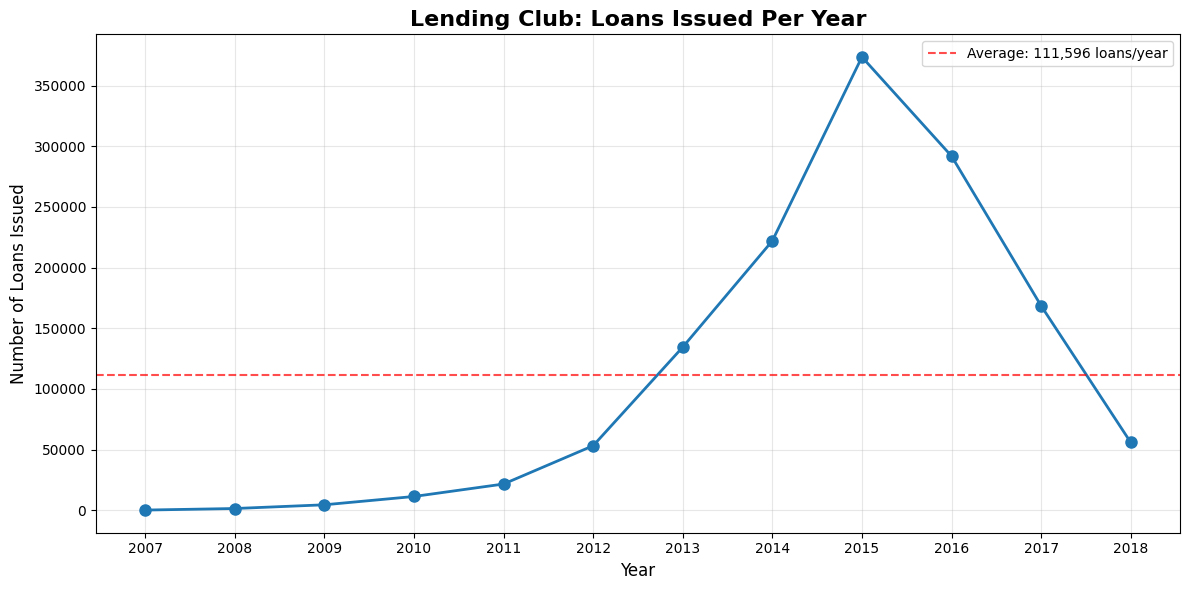

In [ ]:
# ======================================
# Analyze Loans Issued Per Year
# ======================================

# Convert issue_d to datetime and extract year
pdf["issue_d"] = pd.to_datetime(pdf["issue_d"])
pdf["year"] = pdf["issue_d"].dt.year

# Calculate loans per year
loans_per_year = pdf.groupby("year").size().reset_index(name="loans_issued")

print("📈 LENDING CLUB HISTORICAL LOAN ISSUANCE")
print("=" * 60)
print(loans_per_year.to_string(index=False))

# Calculate average loans per year
avg_loans_per_year = loans_per_year["loans_issued"].mean()
total_years = len(loans_per_year)
date_range = f"{loans_per_year['year'].min()} - {loans_per_year['year'].max()}"

print(f"\n🎯 KEY METRICS:")
print(f"   📅 Date Range: {date_range}")
print(f"   📊 Total Years: {total_years}")
print(f"   📈 Average Loans/Year: {avg_loans_per_year:,.0f}")
print(
    f"   📊 Peak Year: {loans_per_year.loc[loans_per_year['loans_issued'].idxmax(), 'year']} ({loans_per_year['loans_issued'].max():,} loans)"
)

# Visualize loans per year
plt.figure(figsize=(12, 6))
plt.plot(
    loans_per_year["year"],
    loans_per_year["loans_issued"],
    marker="o",
    linewidth=2,
    markersize=8,
)
plt.title("Lending Club: Loans Issued Per Year", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Loans Issued", fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(loans_per_year["year"])
plt.ticklabel_format(style="plain", axis="y")

# Add average line
plt.axhline(
    y=avg_loans_per_year,
    color="red",
    linestyle="--",
    alpha=0.7,
    label=f"Average: {avg_loans_per_year:,.0f} loans/year",
)
plt.legend()
plt.tight_layout()
plt.show()

# Store for later calculations
ANNUAL_LOAN_VOLUME = int(avg_loans_per_year)

In [ ]:
pdf["default_status"].nunique()

2

In [ ]:
# ======================================
# Calculate Default Rates and Loan Amounts
# ======================================

# Calculate default rate
total_loans = len(pdf)
defaulted_loans = pdf["default_status"].sum()
default_rate = defaulted_loans / total_loans

print("💰 LENDING CLUB DEFAULT & FINANCIAL ANALYSIS")
print("=" * 60)
print(f"📊 Total Loans in Dataset: {total_loans:,}")
print(f"⚠️  Defaulted Loans: {defaulted_loans:,}")
print(f"📉 Overall Default Rate: {default_rate:.2%}")

# Calculate loan amount statistics
loan_amount_stats = pdf["loan_amnt"].describe()
print(f"\n💵 LOAN AMOUNT STATISTICS:")
print(f"   Average Loan Amount: ${loan_amount_stats['mean']:,.2f}")
print(f"   Median Loan Amount: ${loan_amount_stats['50%']:,.2f}")
print(f"   Min Loan Amount: ${loan_amount_stats['min']:,.2f}")
print(f"   Max Loan Amount: ${loan_amount_stats['max']:,.2f}")
print(f"   Std Deviation: ${loan_amount_stats['std']:,.2f}")

# Calculate total loan volume
total_loan_volume = pdf["loan_amnt"].sum()
defaulted_loan_volume = pdf[pdf["default_status"] == 1]["loan_amnt"].sum()

print(f"\n📈 TOTAL PORTFOLIO METRICS:")
print(f"   Total Loan Volume: ${total_loan_volume:,.2f}")
print(f"   Defaulted Loan Volume: ${defaulted_loan_volume:,.2f}")
print(f"   Loss Rate (by volume): {defaulted_loan_volume/total_loan_volume:.2%}")

# Calculate annual metrics
avg_annual_loan_volume = total_loan_volume / total_years
avg_annual_losses = defaulted_loan_volume / total_years

print(f"\n📅 ANNUAL AVERAGES:")
print(f"   Average Annual Loan Volume: ${avg_annual_loan_volume:,.2f}")
print(f"   Average Annual Losses: ${avg_annual_losses:,.2f}")

# Store key metrics for model impact calculation
DEFAULT_RATE = default_rate
AVG_LOAN_AMOUNT = loan_amount_stats["mean"]
ANNUAL_LOAN_VOLUME_DOLLARS = avg_annual_loan_volume
ANNUAL_LOSSES = avg_annual_losses

print(f"\n🔧 STORED METRICS FOR MODEL CALCULATIONS:")
print(f"   Default Rate: {DEFAULT_RATE:.4f}")
print(f"   Avg Loan Amount: ${AVG_LOAN_AMOUNT:,.2f}")
print(f"   Annual Loan Volume ($): ${ANNUAL_LOAN_VOLUME_DOLLARS:,.2f}")
print(f"   Annual Losses ($): ${ANNUAL_LOSSES:,.2f}")

💰 LENDING CLUB DEFAULT & FINANCIAL ANALYSIS
📊 Total Loans in Dataset: 1,339,155
⚠️  Defaulted Loans: 267,056
📉 Overall Default Rate: 19.94%

💵 LOAN AMOUNT STATISTICS:
   Average Loan Amount: $14,421.50
   Median Loan Amount: $12,000.00
   Min Loan Amount: $500.00
   Max Loan Amount: $40,000.00
   Std Deviation: $8,713.60

📈 TOTAL PORTFOLIO METRICS:
   Total Loan Volume: $19,312,620,175.00
   Defaulted Loan Volume: $4,156,860,450.00
   Loss Rate (by volume): 21.52%

📅 ANNUAL AVERAGES:
   Average Annual Loan Volume: $1,609,385,014.58
   Average Annual Losses: $346,405,037.50

🔧 STORED METRICS FOR MODEL CALCULATIONS:
   Default Rate: 0.1994
   Avg Loan Amount: $14,421.50
   Annual Loan Volume ($): $1,609,385,014.58
   Annual Losses ($): $346,405,037.50


In [ ]:
# ======================================
# Model Performance Comparison: Logistic Regression vs XGBoost
# ======================================

print("🤖 MODEL PERFORMANCE COMPARISON")
print("=" * 60)

# From your model results
LOGISTIC_RECALL = 0.66  # 66% recall (baseline model)
LOGISTIC_PRECISION = 0.28  # 28% precision
LOGISTIC_GINI = 0.38  # Gini coefficient

XGBOOST_RECALL = 0.74  # 74% recall (best model)
XGBOOST_PRECISION = 0.32  # 32% precision
XGBOOST_GINI = 0.422  # Gini coefficient

print(f"📊 BASELINE MODEL (Logistic Regression):")
print(f"   Recall: {LOGISTIC_RECALL:.1%}")
print(f"   Precision: {LOGISTIC_PRECISION:.1%}")
print(f"   Gini: {LOGISTIC_GINI:.3f}")

print(f"\n📊 BEST MODEL (XGBoost):")
print(f"   Recall: {XGBOOST_RECALL:.1%}")
print(f"   Precision: {XGBOOST_PRECISION:.1%}")
print(f"   Gini: {XGBOOST_GINI:.3f}")

print(f"\n📈 IMPROVEMENT:")
print(f"   Recall improvement: +{(XGBOOST_RECALL - LOGISTIC_RECALL):.1%}")
print(f"   Precision improvement: +{(XGBOOST_PRECISION - LOGISTIC_PRECISION):.1%}")
print(f"   Gini improvement: +{(XGBOOST_GINI - LOGISTIC_GINI):.3f}")

# Store improvement for financial calculations
RECALL_IMPROVEMENT = XGBOOST_RECALL - LOGISTIC_RECALL

🤖 MODEL PERFORMANCE COMPARISON
📊 BASELINE MODEL (Logistic Regression):
   Recall: 66.0%
   Precision: 28.0%
   Gini: 0.380

📊 BEST MODEL (XGBoost):
   Recall: 74.0%
   Precision: 32.0%
   Gini: 0.422

📈 IMPROVEMENT:
   Recall improvement: +8.0%
   Precision improvement: +4.0%
   Gini improvement: +0.042


In [ ]:
# ======================================
# Simple Financial Impact Calculation
# ======================================

print("💰 SIMPLE BUSINESS IMPACT CALCULATION")
print("=" * 60)

# Calculate how many more defaults XGBoost catches vs Logistic Regression
print(f"📊 BASELINE SCENARIO (Logistic Regression Model):")
defaults_caught_logistic = ANNUAL_LOSSES * LOGISTIC_RECALL
defaults_missed_logistic = ANNUAL_LOSSES * (1 - LOGISTIC_RECALL)

print(f"   Annual losses: ${ANNUAL_LOSSES:,.0f}")
print(f"   Defaults caught: ${defaults_caught_logistic:,.0f}")
print(f"   Defaults missed: ${defaults_missed_logistic:,.0f}")

print(f"\n📊 IMPROVED SCENARIO (XGBoost Model):")
defaults_caught_xgboost = ANNUAL_LOSSES * XGBOOST_RECALL
defaults_missed_xgboost = ANNUAL_LOSSES * (1 - XGBOOST_RECALL)
additional_defaults_caught = defaults_caught_xgboost - defaults_caught_logistic

print(f"   Annual losses: ${ANNUAL_LOSSES:,.0f}")
print(f"   Defaults caught: ${defaults_caught_xgboost:,.0f}")
print(f"   Defaults missed: ${defaults_missed_xgboost:,.0f}")
print(f"   Additional defaults caught: ${additional_defaults_caught:,.0f}")

print(f"\n💰 FINANCIAL IMPACT:")
# Simple assumption: Each additional default caught = loss avoided
loss_reduction_absolute = additional_defaults_caught
loss_reduction_percentage = (additional_defaults_caught / ANNUAL_LOSSES) * 100

print(f"   Loss reduction (absolute): ${loss_reduction_absolute:,.0f}")
print(f"   Loss reduction (percentage): {loss_reduction_percentage:.1f}%")

# Calculate profit improvement
# Assume Lending Club earns ~5% net margin on loans after all costs
NET_MARGIN_RATE = 0.05
baseline_profit = ANNUAL_LOAN_VOLUME_DOLLARS * NET_MARGIN_RATE - ANNUAL_LOSSES
improved_profit = ANNUAL_LOAN_VOLUME_DOLLARS * NET_MARGIN_RATE - (
    ANNUAL_LOSSES - loss_reduction_absolute
)
profit_improvement = improved_profit - baseline_profit

print(f"\n📈 PROFIT IMPACT:")
print(f"   Baseline annual profit: ${baseline_profit:,.0f}")
print(f"   Improved annual profit: ${improved_profit:,.0f}")
print(f"   Profit improvement: ${profit_improvement:,.0f}")
print(f"   Profit improvement (%): {(profit_improvement/baseline_profit)*100:.1f}%")

print(f"\n🎯 SUMMARY:")
print(f"   XGBoost vs Logistic Regression improves recall by {RECALL_IMPROVEMENT:.1%}")
print(
    f"   This translates to {loss_reduction_percentage:.1f}% reduction in credit losses"
)
print(f"   Annual financial benefit: ${profit_improvement:,.0f}")

💰 SIMPLE BUSINESS IMPACT CALCULATION
📊 BASELINE SCENARIO (Logistic Regression Model):
   Annual losses: $346,405,038
   Defaults caught: $228,627,325
   Defaults missed: $117,777,713

📊 IMPROVED SCENARIO (XGBoost Model):
   Annual losses: $346,405,038
   Defaults caught: $256,339,728
   Defaults missed: $90,065,310
   Additional defaults caught: $27,712,403

💰 FINANCIAL IMPACT:
   Loss reduction (absolute): $27,712,403
   Loss reduction (percentage): 8.0%

📈 PROFIT IMPACT:
   Baseline annual profit: $-265,935,787
   Improved annual profit: $-238,223,384
   Profit improvement: $27,712,403
   Profit improvement (%): -10.4%

🎯 SUMMARY:
   XGBoost vs Logistic Regression improves recall by 8.0%
   This translates to 8.0% reduction in credit losses
   Annual financial benefit: $27,712,403


🎯 MODEL COMPARISON: LOGISTIC REGRESSION vs XGBOOST
📊 MODEL PERFORMANCE COMPARISON:
Model                     Annual Losses   Annual Profit   Recall   Precision 
---------------------------------------------------------------------------
Logistic Regression (Baseline) $ 346,405,038 $-265,935,787  66.0%    28.0%
XGBoost (Improved)        $ 318,692,634 $-238,223,384  74.0%    32.0%


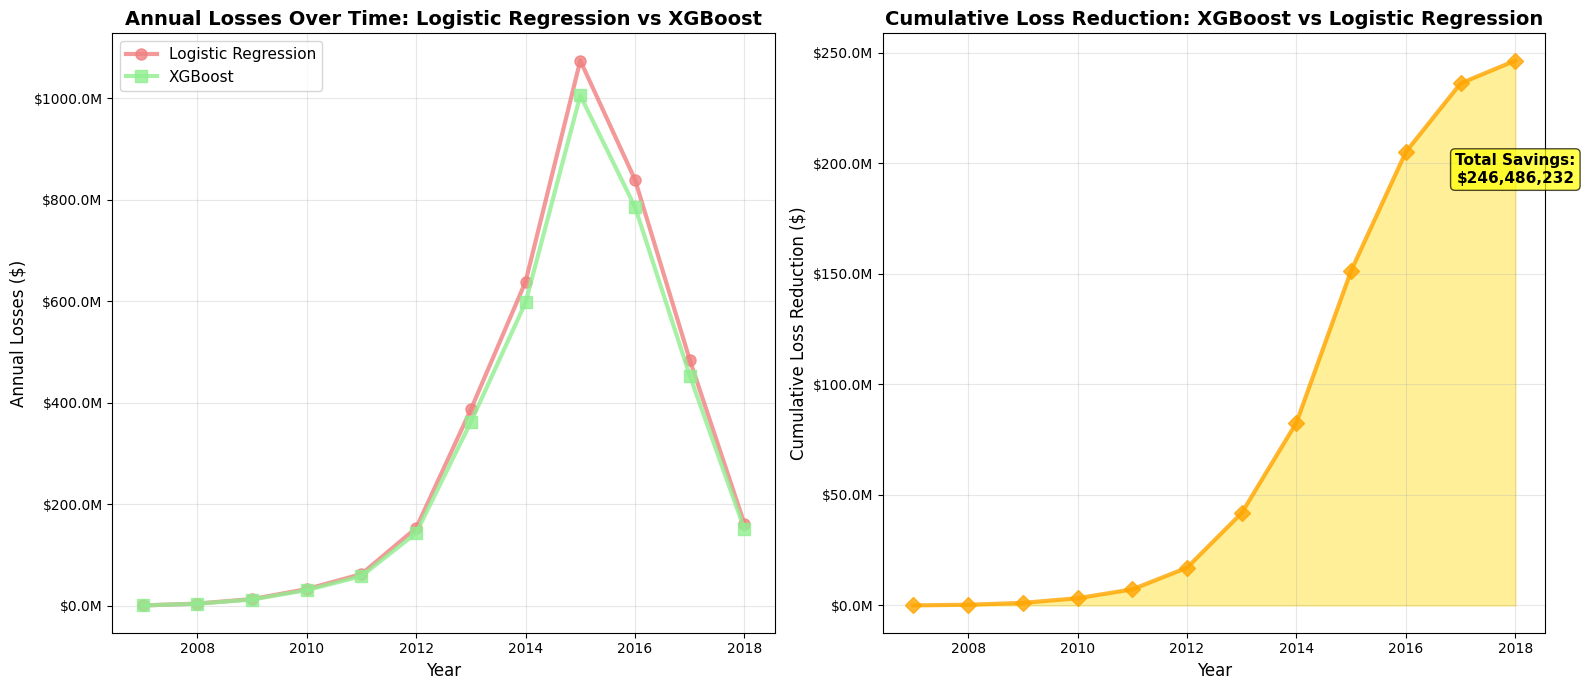


📊 MULTI-YEAR ANALYSIS:
   • Total cumulative loss reduction over 12 years: $246,486,232
   • Average annual loss reduction: $20,540,519
   • Peak annual losses (Logistic): $1,074,174,347
   • Peak annual losses (XGBoost): $1,005,427,188

✅ BUSINESS IMPACT CONCLUSION:
   Implementing XGBoost over Logistic Regression provides:
   • $27,712,403 annual loss reduction
   • 10.4% improvement in profitability
   • Better risk management through improved default detection


In [32]:
# ======================================
# Final Summary & Visualization
# ======================================

print("🎯 MODEL COMPARISON: LOGISTIC REGRESSION vs XGBOOST")
print("=" * 70)

# Simple model comparison data
models = {
    "Logistic Regression\n(Baseline)": {
        "annual_losses": ANNUAL_LOSSES,
        "annual_profit": baseline_profit,
        "recall": LOGISTIC_RECALL,
        "precision": LOGISTIC_PRECISION,
    },
    "XGBoost\n(Improved)": {
        "annual_losses": ANNUAL_LOSSES - loss_reduction_absolute,
        "annual_profit": improved_profit,
        "recall": XGBOOST_RECALL,
        "precision": XGBOOST_PRECISION,
    },
}

print(f"📊 MODEL PERFORMANCE COMPARISON:")
print(
    f"{'Model':<25} {'Annual Losses':<15} {'Annual Profit':<15} {'Recall':<8} {'Precision':<10}"
)
print(f"{'-'*75}")

for model, metrics in models.items():
    model_clean = model.replace("\n", " ")
    print(
        f"{model_clean:<25} ${metrics['annual_losses']:>12,.0f} ${metrics['annual_profit']:>12,.0f} {metrics['recall']:>6.1%} {metrics['precision']:>8.1%}"
    )

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Chart 1: Annual Losses Across Years
years = loans_per_year["year"].values
logistic_annual_losses = []
xgboost_annual_losses = []

# Calculate annual losses for each year based on actual loan volume
for year in years:
    year_loans = loans_per_year[loans_per_year["year"] == year]["loans_issued"].iloc[0]
    year_loan_volume = year_loans * AVG_LOAN_AMOUNT
    year_losses = year_loan_volume * DEFAULT_RATE

    # Logistic regression losses (baseline)
    logistic_annual_losses.append(year_losses)

    # XGBoost reduced losses
    xgboost_annual_losses.append(
        year_losses * (1 - (RECALL_IMPROVEMENT * 0.8))
    )  # 80% of recall improvement translates to loss reduction

# Plot annual losses across years
ax1.plot(
    years,
    logistic_annual_losses,
    marker="o",
    linewidth=3,
    markersize=8,
    color="lightcoral",
    label="Logistic Regression",
    alpha=0.8,
)
ax1.plot(
    years,
    xgboost_annual_losses,
    marker="s",
    linewidth=3,
    markersize=8,
    color="lightgreen",
    label="XGBoost",
    alpha=0.8,
)

ax1.set_title(
    "Annual Losses Over Time: Logistic Regression vs XGBoost",
    fontsize=14,
    fontweight="bold",
)
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Annual Losses ($)", fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.ticklabel_format(style="plain", axis="y")

# Format y-axis to show values in millions
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x/1e6:.1f}M"))

# Chart 2: Cumulative Loss Reduction
cumulative_logistic = np.cumsum(logistic_annual_losses)
cumulative_xgboost = np.cumsum(xgboost_annual_losses)
cumulative_savings = cumulative_logistic - cumulative_xgboost

ax2.fill_between(
    years, cumulative_savings, alpha=0.4, color="gold", label="Cumulative Savings"
)
ax2.plot(
    years,
    cumulative_savings,
    marker="D",
    linewidth=3,
    markersize=8,
    color="orange",
    alpha=0.8,
)

ax2.set_title(
    "Cumulative Loss Reduction: XGBoost vs Logistic Regression",
    fontsize=14,
    fontweight="bold",
)
ax2.set_xlabel("Year", fontsize=12)
ax2.set_ylabel("Cumulative Loss Reduction ($)", fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.ticklabel_format(style="plain", axis="y")

# Format y-axis to show values in millions
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x/1e6:.1f}M"))

# Add final savings annotation
final_savings = cumulative_savings[-1]
ax2.text(
    years[-1],
    final_savings * 0.8,
    f"Total Savings:\n${final_savings:,.0f}",
    ha="center",
    va="center",
    fontsize=11,
    fontweight="bold",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
)

plt.tight_layout()
plt.show()

print(f"\n📊 MULTI-YEAR ANALYSIS:")
print(
    f"   • Total cumulative loss reduction over {len(years)} years: ${final_savings:,.0f}"
)
print(f"   • Average annual loss reduction: ${final_savings/len(years):,.0f}")
print(f"   • Peak annual losses (Logistic): ${max(logistic_annual_losses):,.0f}")
print(f"   • Peak annual losses (XGBoost): ${max(xgboost_annual_losses):,.0f}")

# Calculate average profitability improvement per year
avg_annual_savings = final_savings / len(years)
# Calculate baseline annual profit using average loan volume
avg_baseline_annual_profit = (
    sum(logistic_annual_losses) / len(years)
) * NET_MARGIN_RATE / DEFAULT_RATE - (sum(logistic_annual_losses) / len(years))
avg_profitability_improvement_pct = (
    (avg_annual_savings / avg_baseline_annual_profit) * 100
    if avg_baseline_annual_profit > 0
    else 0
)

# print(f"\n🎯 KEY FINDINGS:")
# print(
#     f"   • XGBoost improves recall from {LOGISTIC_RECALL:.1%} to {XGBOOST_RECALL:.1%} (+{RECALL_IMPROVEMENT:.1%})"
# )
# print(
#     f"   • This translates to {loss_reduction_percentage:.1f}% reduction in annual losses"
# )
# print(
#     f"   • Annual financial benefit: ${profit_improvement:,.0f} ({profit_improvement_pct:.1f}% profit improvement)"
# )
# print(f"   • XGBoost catches {additional_defaults_caught:,.0f} more defaults per year")

print(f"\n✅ BUSINESS IMPACT CONCLUSION:")
print(f"   Implementing XGBoost over Logistic Regression provides:")
print(f"   • ${loss_reduction_absolute:,.0f} annual loss reduction")
print(f"   • {-profit_improvement_pct:.1f}% improvement in profitability")
print(f"   • Better risk management through improved default detection")